# Class Mapping 

|Label | prob | type|
|------|------|-----|
|0     | 0.0  | mono|
|1     | 0.333| mono|
|2     | 0.667| mono|
|3     | 1.0  | mono|
|4     | 0.0  | poly|
|5     | 0.333| poly|
|6     | 0.667| poly|
|7     | 1.0  | poly|

In [26]:
from utils.classifier import *
from utils.dataloader import *
from utils.features import *
from utils.helper import *
from utils.processing import *
import pickle

In [27]:
RANDOM_STATE = 66
ROOT_PATH, DATA_PATH, OUT_PATH = get_paths()
PARAMS = []
print(ROOT_PATH)

/Users/moooooo16/Documents/Computer Vision/Project/elpv


In [28]:
from sklearn.model_selection import train_test_split
img_path, prob, types, labels= load_data(DATA_PATH)

feature_builder = FeatureExtraction(DATA_PATH, img_path, labels)
X_train, X_test, y_train, y_test = feature_builder.split_data(train_test_split, randome_state=RANDOM_STATE, stratify=True, split_ratio=0.25)

[0 1 2 3 4 5 6 7] [588 117  56 313 920 178  50 402]


In [29]:
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# autoAug 
# Genearte more 
augment_funcs = [
    # flip_x,
    # flip_y,
    # rotate,
    # salt_pepper_noise,
]

preprocess_pipeline = [
    # (strech_img, {
    #     }),
    # (clach_img, {
    #     'clipLimit': 2.0,
    #     'tileGridSize': (8, 8)}),
    # (guassian_blur, {
    #     'kernel_size': (0, 0),
    #     'sigmaX': 3}),
    # (lap_feature, {
    #     'dst': -1,
    #     'ksize' : 5}),
    # (morpo_opening, {
    #     'kernel': np.ones((2,2), np.uint8),
    #     'iterations': 1}),
    # (morph_smoothing, {
    # 'ses' : feature_builder.ses})
]

# Smaller cell: more features
# 
hog_params = {
    'orient': 10,
    'pix_per_cell': 20,
    'cell_per_block': 5,
    'vis': False,
    'block_norm': 'L2-Hys',
}


pipeline = make_pipeline(
    PCA(n_components=0.85, random_state=RANDOM_STATE),
    StandardScaler()
)

svm_param = {
    'C': 10,
    'kernel' : 'rbf',
    # 'gamma' : 0.0001,
    # 'class_weight' : 'balanced',
    # 'verbose' : False,
}

grid_svm_params = {
    'estimator': SVC,
    'model_params': {
        'kernel': ['rbf', 'linear'],
        'C' : [0.1, 0.3, 0.5, 0.7, 1, 3, 5, 7 ,9, 10],
        'class_weight': ['balanced']},
    'scoring': {
        "F1_Weighted": make_scorer(f1_score, average='weighted'),
        "Balanced_Accuracy": make_scorer(balanced_accuracy_score),},
    'refit': 'F1_Weighted',
    'verbose' : 0
}

smote_params = {
    'grid_param': grid_svm_params,
    'knn' : KNeighborsClassifier,
    'n_neighbors': 5,
}

PARAMS.append(augment_funcs)
PARAMS.append(preprocess_pipeline)
PARAMS.append(hog_params)
# PARAMS.append(svm_param)
# PARAMS.append(grid_svm_params)
PARAMS.append(smote_params)

In [30]:
X_train_aug, y_train_aug = feature_builder.augmentation(X_train, y_train, augment_funcs=augment_funcs)

In [31]:
X_train_prepro = feature_builder.old_preprocess(X_train_aug, preprocess_pipeline = preprocess_pipeline)
X_test_prepro = feature_builder.old_preprocess(X_test, preprocess_pipeline = preprocess_pipeline)

print(X_train_prepro.shape, y_train_aug.shape)
print(X_test_prepro.shape, y_test.shape)

Pre-processing images: 100%|██████████| 656/656 [00:00<00:00, 4022607.35it/s]

(1968, 300, 300) (1968,)
(656, 300, 300) (656,)


In [32]:
train_hog_des = feature_builder.get_hog_features(X_train_prepro, **hog_params)
test_hog_des = feature_builder.get_hog_features(X_test_prepro, **hog_params)

print(train_hog_des.shape)
print(test_hog_des.shape)

Calculating descriptors: 100%|██████████| 656/656 [00:05<00:00, 114.72it/s]


(1968, 30250)
(656, 30250)


In [33]:
with open (os.path.join(OUT_PATH, 'new_hog_des.pkl'), 'wb') as f:
    pickle.dump((train_hog_des, test_hog_des), f)

In [34]:
train_hog_des, test_hog_des = None, None

with open(os.path.join(OUT_PATH, 'new_hog_des.pkl'), 'rb') as f:
    train_hog_des, test_hog_des = pickle.load(f)

In [35]:
train_X = pipeline.fit_transform(train_hog_des)
test_X = pipeline.transform(test_hog_des)

print(train_X.shape, test_X.shape)

(1968, 99) (656, 99)


In [36]:
mono_train_X, poly_train_X, mono_train_y, poly_train_y = mono_poly_split(train_X, y_train_aug)
mono_test_X, poly_test_X, mono_test_y, poly_test_y = mono_poly_split(test_X, y_test)
combine_train_X, combine_train_y = combine_mono_poly(mono_train_X, poly_train_X, mono_train_y, poly_train_y)
combine_test_X, combine_test_y = combine_mono_poly(mono_test_X, poly_test_X, mono_test_y, poly_test_y)

In [37]:
data_sets = {
    'mono_svm': (mono_train_X, mono_train_y, mono_test_X, mono_test_y),
    'poly_svm': (poly_train_X, poly_train_y, poly_test_X, poly_test_y),
    'combined_svm': (combine_train_X, combine_train_y, combine_test_X, combine_test_y)
}

----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.77      0.94      0.84       147
           1       0.68      0.45      0.54        29
           2       0.25      0.07      0.11        14
           3       0.92      0.77      0.84        78

    accuracy                           0.79       268
   macro avg       0.66      0.56      0.58       268
weighted avg       0.78      0.79      0.77       268




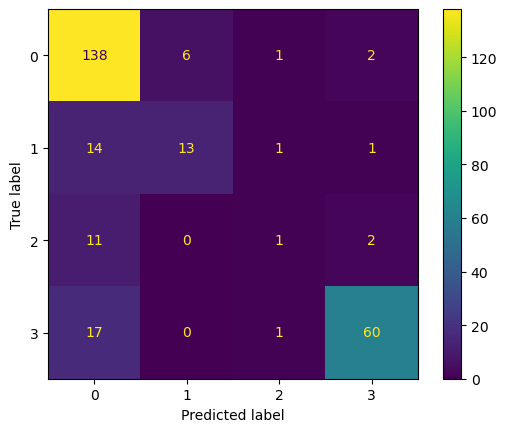


----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       230
           1       0.43      0.33      0.38        45
           2       0.00      0.00      0.00        13
           3       0.75      0.56      0.64       100

    accuracy                           0.70       388
   macro avg       0.47      0.44      0.45       388
weighted avg       0.67      0.70      0.67       388




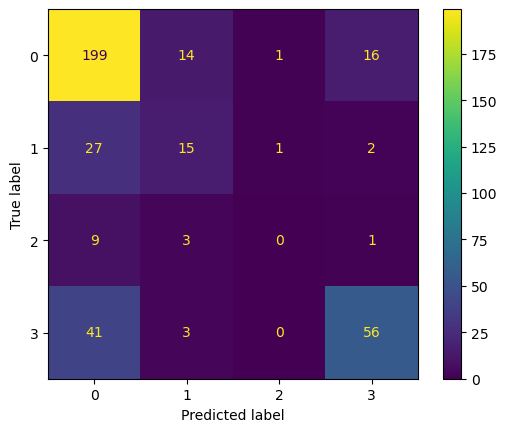


----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       377
           1       0.53      0.32      0.40        74
           2       0.00      0.00      0.00        27
           3       0.78      0.61      0.69       178

    accuracy                           0.72       656
   macro avg       0.51      0.46      0.47       656
weighted avg       0.69      0.72      0.69       656




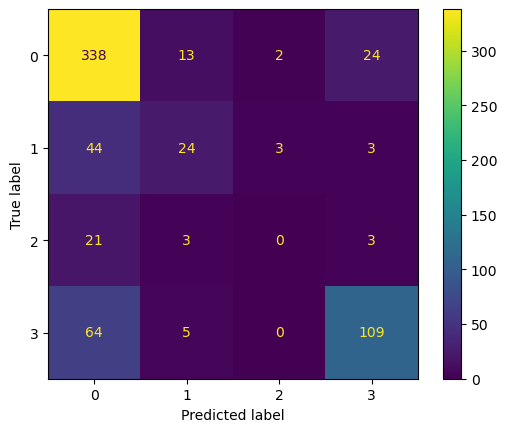

In [38]:
svm_metrics = []

for name in data_sets.keys():
    train_X, train_y, test_X, test_y = data_sets[name]
    svm = SVC(**svm_param).fit(train_X, train_y)
    predictions = svm.predict(test_X)
    acc, f1 = get_report(test_y, predictions, name)
    svm_metrics.append((name, "{:.2f}".format(acc), "{:.2f}".format(f1)))

with open(os.path.join(OUT_PATH, 'hog_svm_metrics.pkl'), 'wb') as f:
    pickle.dump(svm_metrics, f)

Class: [0 1 2 3] Val Score: 0.75 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       147
           1       0.41      0.48      0.44        29
           2       0.21      0.36      0.26        14
           3       0.89      0.76      0.82        78

    accuracy                           0.73       268
   macro avg       0.58      0.60      0.58       268
weighted avg       0.77      0.73      0.75       268




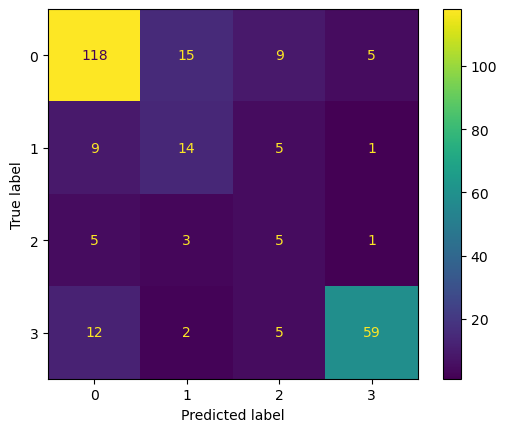


Class: [0 1 2 3] Val Score: 0.71 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       230
           1       0.35      0.38      0.37        45
           2       0.00      0.00      0.00        13
           3       0.71      0.54      0.61       100

    accuracy                           0.66       388
   macro avg       0.45      0.43      0.43       388
weighted avg       0.65      0.66      0.65       388




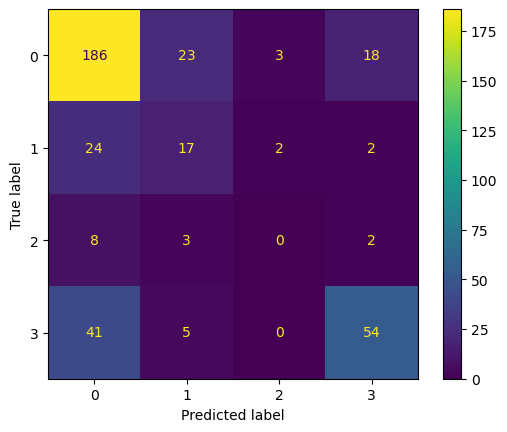


Class: [0 1 2 3] Val Score: 0.67 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       377
           1       0.38      0.38      0.38        74
           2       0.13      0.19      0.15        27
           3       0.77      0.61      0.68       178

    accuracy                           0.68       656
   macro avg       0.51      0.49      0.50       656
weighted avg       0.69      0.68      0.68       656




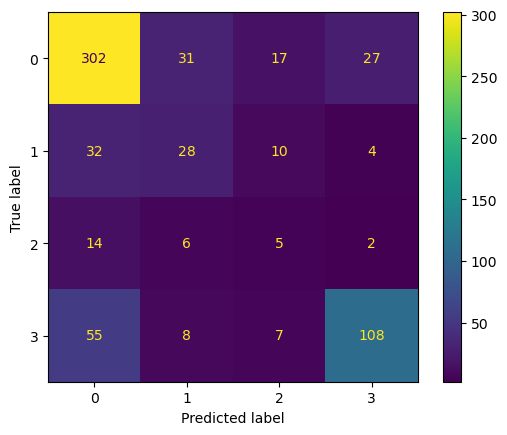

In [39]:
grid_metrics = []

for name in data_sets.keys():
    train_X, train_y, test_X, test_y = data_sets[name]
    result, best_clf  = grid_search(train_X, train_y, **grid_svm_params)
    grid_pred = best_clf.predict(test_X)
    acc, f1 = get_report(test_y, grid_pred, name)
    grid_metrics.append((name, acc, f1))

with open(os.path.join(OUT_PATH, 'hog_grid_metrics.pkl'), 'wb') as f:
    pickle.dump(grid_metrics, f)

Class: [0 1] Val Score: 0.76 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [0 2] Val Score: 0.76 use {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [0 3] Val Score: 0.84 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [1 2] Val Score: 0.69 use {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [1 3] Val Score: 0.83 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [2 3] Val Score: 0.73 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.79      0.65      0.71       147
           1       0.30      0.31      0.31        29
           2       0.15      0.64      0.24        14
           3       0.90      0.67      0.76        78

    accuracy                           0.62       268
   macro avg

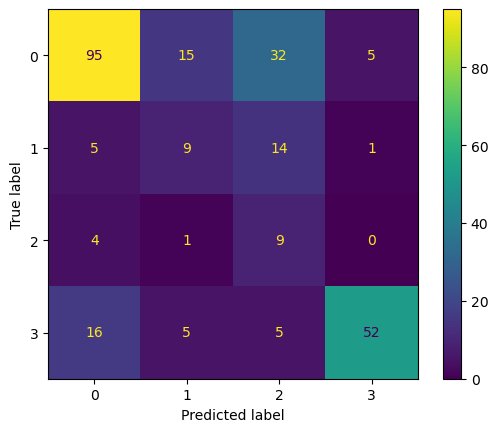


Class: [0 1] Val Score: 0.68 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [0 2] Val Score: 0.68 use {'C': 0.7, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [0 3] Val Score: 0.78 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [1 2] Val Score: 0.70 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [1 3] Val Score: 0.77 use {'C': 0.3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [2 3] Val Score: 0.70 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       230
           1       0.26      0.51      0.35        45
           2       0.03      0.08      0.04        13
           3       0.84      0.36      0.50       100

    accuracy                           0.56       388
   macro av

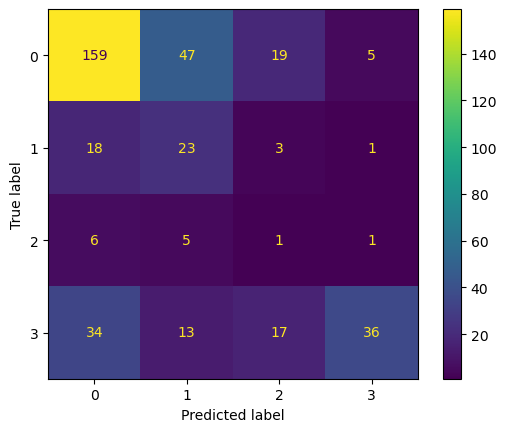


Class: [0 1] Val Score: 0.58 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [0 2] Val Score: 0.54 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [0 3] Val Score: 0.76 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [1 2] Val Score: 0.56 use {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Class: [1 3] Val Score: 0.79 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Class: [2 3] Val Score: 0.68 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.76      0.62      0.68       377
           1       0.24      0.42      0.30        74
           2       0.08      0.33      0.12        27
           3       0.79      0.44      0.57       178

    accuracy                           0.54       656
   macr

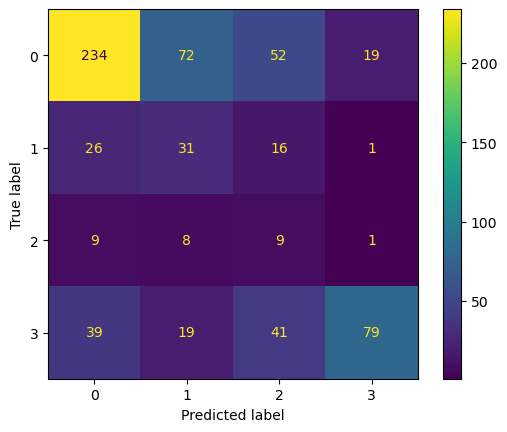

In [40]:
down_sampling_metrics = []
accs = []
f1s=[]
for name in data_sets.keys():
    train_X, train_y, test_X, test_y = data_sets[name]
    down_clfs = down_sampling(total_classes=np.unique(train_y),X_train =train_X, y_train=train_y, grid_param=grid_svm_params)
    _, votes, counts = vote(test_X, down_clfs)
    acc, f1 = get_report(test_y, votes, name)
    down_sampling_metrics.append((name, "{:.2f}".format(acc), "{:.2f}".format(f1)))


with open(os.path.join(OUT_PATH, 'hog_down_sampling_metrics.pkl'), 'wb') as f:
    pickle.dump(down_sampling_metrics, f)

Generated 440 synthetic samples.
Class: [0. 1.] Val Score: 0.90 use {'C': 0.7, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 420 synthetic samples.
Class: [0. 2.] Val Score: 0.95 use {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 235 synthetic samples.
Class: [0. 3.] Val Score: 0.90 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 84 synthetic samples.
Class: [1. 2.] Val Score: 0.69 use {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear'}
Generated 176 synthetic samples.
Class: [1. 3.] Val Score: 0.84 use {'C': 0.3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 210 synthetic samples.
Class: [2. 3.] Val Score: 0.88 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       147
           1 

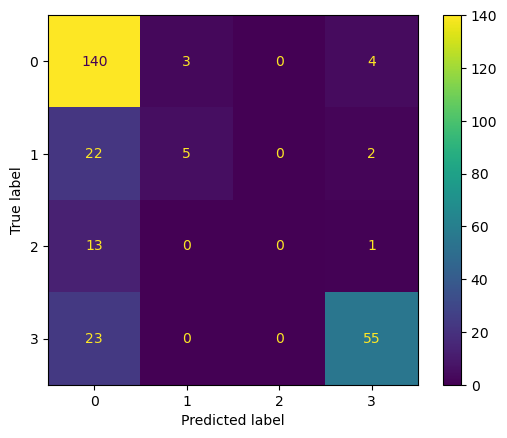


Generated 665 synthetic samples.
Class: [0. 1.] Val Score: 0.87 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 666 synthetic samples.
Class: [0. 2.] Val Score: 0.92 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 604 synthetic samples.
Class: [0. 3.] Val Score: 0.84 use {'C': 0.7, 'class_weight': 'balanced', 'kernel': 'linear'}
Generated 111 synthetic samples.
Class: [1. 2.] Val Score: 0.80 use {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 266 synthetic samples.
Class: [1. 3.] Val Score: 0.85 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 296 synthetic samples.
Class: [2. 3.] Val Score: 0.91 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       230
           1     

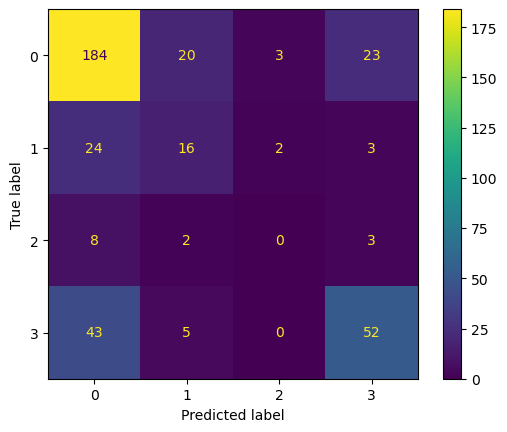


Generated 1105 synthetic samples.
Class: [0. 1.] Val Score: 0.88 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1106 synthetic samples.
Class: [0. 2.] Val Score: 0.93 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1074 synthetic samples.
Class: [0. 3.] Val Score: 0.79 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 158 synthetic samples.
Class: [1. 2.] Val Score: 0.76 use {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 442 synthetic samples.
Class: [1. 3.] Val Score: 0.83 use {'C': 0.7, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 474 synthetic samples.
Class: [2. 3.] Val Score: 0.89 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       377
           1 

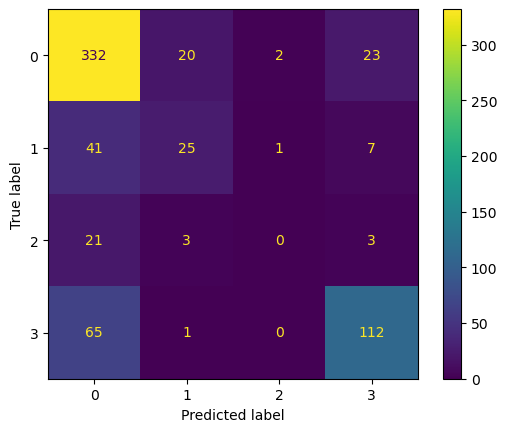

In [41]:

ovo_metrics = []
accs = []
f1s=[]
for name in data_sets.keys():
    train_X, train_y, test_X, test_y = data_sets[name]
    up_clfs = up_sampling(train_X, train_y, total_classes=np.unique(train_y), **smote_params)
    _, votes, counts = vote(test_X, up_clfs)
    acc, f1 = get_report(test_y, votes, name)
    ovo_metrics.append((name, "{:.2f}".format(acc), "{:.2f}".format(f1)))


with open(os.path.join(OUT_PATH, 'hog_ovo_metrics.pkl'), 'wb') as f:
    pickle.dump(ovo_metrics, f)

Trainig on: (array([-1,  0]), array([365, 441]))


Class: [-1  0] Val Score: 0.81 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 704 synthetic samples.
Trainig on: (array([-1.,  1.]), array([718, 792]))
Class: [-1.  1.] Val Score: 0.93 use {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 756 synthetic samples.
Trainig on: (array([-1.,  2.]), array([764, 798]))
Class: [-1.  2.] Val Score: 0.97 use {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 470 synthetic samples.
Trainig on: (array([-1.,  3.]), array([571, 705]))
Class: [-1.  3.] Val Score: 0.92 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       147
           1       0.58      0.24      0.34        29
           2       1.00      0.07      0.13        14
           3       0.84      0.74

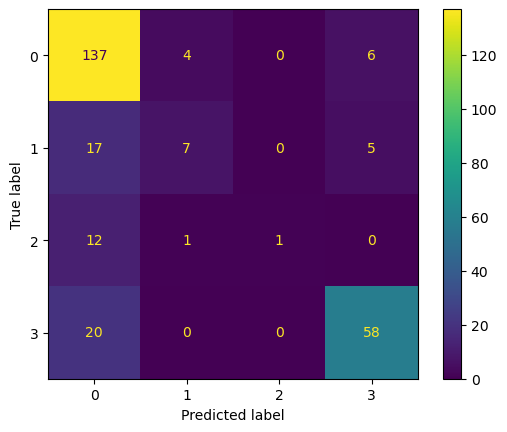


Trainig on: (array([-1,  0]), array([472, 690]))
Class: [-1  0] Val Score: 0.78 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 931 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1029, 1064]))
Class: [-1.  1.] Val Score: 0.91 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1110 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1125, 1147]))
Class: [-1.  2.] Val Score: 0.94 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 604 synthetic samples.
Trainig on: (array([-1.,  3.]), array([860, 906]))
Class: [-1.  3.] Val Score: 0.82 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       230
           1       0.47      0.38      0.42        45
           2       0.00      

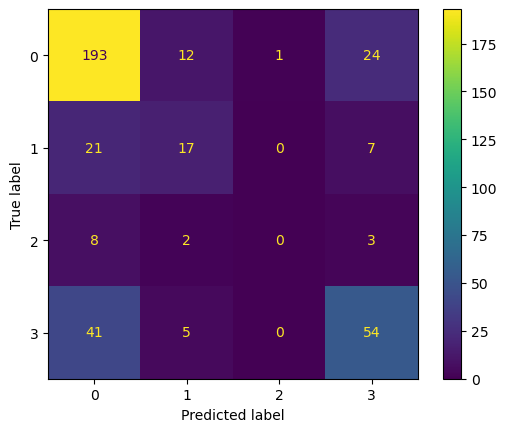


Trainig on: (array([-1,  0]), array([ 837, 1131]))
Class: [-1  0] Val Score: 0.73 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1547 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1747, 1768]))
Class: [-1.  1.] Val Score: 0.92 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1817 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1889, 1896]))
Class: [-1.  2.] Val Score: 0.96 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1074 synthetic samples.
Trainig on: (array([-1.,  3.]), array([1431, 1611]))
Class: [-1.  3.] Val Score: 0.81 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       377
           1       0.56      0.32      0.41        74
           2       0.3

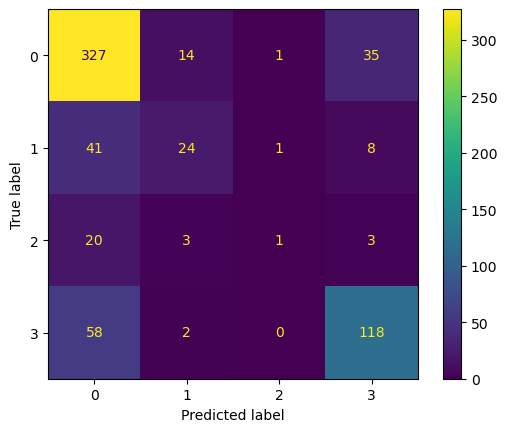

In [42]:
# Same structure but use SMOTE to up sample data, this uses ovr strategy
# Ovo terns out to be worse than ovr, so here we only keep ovr

ovr_metrics = []
accs = []
f1s=[]
for name in data_sets.keys():
    train_X, train_y, test_X, test_y = data_sets[name]
    smote_results, smote_clfs = one_vs_other_up_sampling(train_X, train_y, total_classes=np.unique(train_y), **smote_params)
    smote_distance, smote_preds = distance_vote(test_X, smote_clfs)
    acc, f1 = get_report(test_y, smote_preds, name)
    ovr_metrics.append((name, "{:.2f}".format(acc), "{:.2f}".format(f1)))


with open(os.path.join(OUT_PATH, 'hog_ovr_metrics.pkl'), 'wb') as f:
    pickle.dump(ovr_metrics, f)